<a href="https://colab.research.google.com/github/victormayowa/deepFECG/blob/main/rawl_of_dwtdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dissertation: Towards Interpretable-by-Design ECG Arrhythmia Classification via Feature Engineered Deep Forests: A Comparative Study

## Author: Victor Mayowa ADELEYE(MB;BS, MSc in view)

In partial fulfillment of my Masters in Data Science at the University of East London

## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [ ]:
!pip install -q wfdb librosa pywavelets ssqueezepy imbalanced-learn shap matplotlib opendatasets kaggle python_speech_features EMD-signal

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 w

In [ ]:
import numpy as np
from datetime import datetime
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
import joblib
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
import pywt
from scipy.stats import skew, kurtosis
import os
import wfdb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt
from PyEMD import EMD
from ssqueezepy import ssq_cwt
import librosa

## Data Loader Configuration

In [ ]:
# --- Constants and Configuration ---
AAMI_CLASSES = {'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0, 'A': 1, 'a': 1, 'J': 1, 'S': 1,
                'V': 2, 'E': 2, 'F': 3, '/': 4, 'f': 4, 'Q': 4}
AAMI_LABELS = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

@dataclass
class ECGRecord:
    signal: np.ndarray; fs: int; ann_positions: np.ndarray; ann_symbols: List[str]; record_id: str = "record"

## Feature Extraction Methods

In [ ]:

def extract_no_transform_features(hb: np.ndarray, fs: int) -> np.ndarray:
    """ Placeholder function for the baseline. Returns an empty array. """
    return np.array([])
def extract_dwt_features(hb: np.ndarray, fs: int, wavelet='db4', level=4, fixed_len=205) -> np.ndarray:
    if len(hb) == 0: return np.zeros(fixed_len)
    max_level = pywt.dwt_max_level(len(hb), pywt.Wavelet(wavelet).dec_len)
    if level > max_level: level = max_level
    coeffs = pywt.wavedec(hb, wavelet=wavelet, level=level)
    features = np.hstack([c for c in coeffs])
    if len(features) < fixed_len:
        return np.pad(features, (0, fixed_len - len(features)), 'constant')
    return features[:fixed_len]

def extract_hht_features(hb: np.ndarray, fs: int, n_imfs=5, fixed_len=60) -> np.ndarray:
    """ Extracts features using Hilbert-Huang Transform with the PyEMD library. """
    if len(hb) < 10: return np.zeros(fixed_len)
    try:
        emd = EMD()
        imfs = emd(hb)
        if imfs.shape[0] == 0: return np.zeros(fixed_len)

        num_to_process = min(n_imfs, imfs.shape[0])
        features = []

        for i in range(num_to_process):
            imf = imfs[i]
            analytic_signal = np.fft.fft(imf)
            inst_amplitude = np.abs(analytic_signal)
            inst_phase = np.unwrap(np.angle(analytic_signal))
            inst_frequency = (np.diff(inst_phase) / (2.0 * np.pi * (1.0 / fs)))

            features.extend([
                np.mean(inst_amplitude), np.std(inst_amplitude), np.max(inst_amplitude),
                np.mean(inst_frequency), np.std(inst_frequency), np.max(inst_frequency)
            ])

        features = np.array(features)
        if len(features) < fixed_len:
            return np.pad(features, (0, fixed_len - len(features)), 'constant')
        return features[:fixed_len]
    except Exception:
        return np.zeros(fixed_len)

def extract_mfcc_features(hb: np.ndarray, fs: int, n_mfcc=20, fixed_len=20) -> np.ndarray:
    if len(hb) == 0: return np.zeros(fixed_len)
    mfccs = librosa.feature.mfcc(y=hb.astype(float), sr=fs, n_mfcc=n_mfcc, n_fft=256, hop_length=64)
    mfcc_mean = np.mean(mfccs, axis=1)
    if len(mfcc_mean) < fixed_len:
         return np.pad(mfcc_mean, (0, fixed_len - len(mfcc_mean)), 'constant')
    return mfcc_mean[:fixed_len]

def extract_sswt_features(hb: np.ndarray, fs: int, fixed_len=64) -> np.ndarray:
    """ Extracts features using Synchrosqueezing Wavelet Transform. """
    if len(hb) < 20: return np.zeros(fixed_len)
    try:
        Tx, Wx, ssq_freqs, *_ = ssq_cwt(hb, wavelet='morlet', fs=fs, nv=32)
        energy = np.abs(Wx)**2
        energy_per_freq = np.sum(energy, axis=1)

        if len(energy_per_freq) < fixed_len:
            return np.pad(energy_per_freq, (0, fixed_len - len(energy_per_freq)))
        return energy_per_freq[:fixed_len]

    except Exception:
        return np.zeros(fixed_len)



## Feature Processing Framework

In [ ]:
def wavelet_denoise_db6(signal: np.ndarray, level: int = 6, wavelet: str = "db6") -> np.ndarray:
    """ Denoises signal using wavelet transform. This is our standard preprocessing step. """
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    coeffs[0] = np.zeros_like(coeffs[0])
    coeffs[-2] = np.zeros_like(coeffs[-2])
    return pywt.waverec(coeffs, wavelet=wavelet)[:len(signal)]

def zscore(x, eps=1e-8):
    m, s = np.mean(x), np.std(x)
    return (x - m) / (s + eps)

def preprocess_record(record: ECGRecord) -> np.ndarray:
    """ Standard preprocessing pipeline for a single ECG record. """
    x = record.signal.astype(float)
    x = wavelet_denoise_db6(x)
    return zscore(x)

@dataclass
class BeatWindowConfig:
    qrs_ms: Tuple[int, int] = (-50, 100)
    post_ms: Tuple[int, int] = (150, 500)
    heartbeat_pts: int = 90
    fs: int = 360

    def ms_to_samples(self, ms: int) -> int:
        return int(round(ms * self.fs / 1000.0))

    def bounds(self, fp: int, length: int) -> Dict[str, slice]:
        qrs_l = max(0, fp + self.ms_to_samples(self.qrs_ms[0]))
        qrs_r = min(length, fp + self.ms_to_samples(self.qrs_ms[1]))
        post_l = max(0, fp + self.ms_to_samples(self.post_ms[0]))
        post_r = min(length, fp + self.ms_to_samples(self.post_ms[1]))
        hb_l = max(0, fp - self.heartbeat_pts)
        hb_r = min(length, fp + self.heartbeat_pts)
        return {"qrs": slice(qrs_l, qrs_r), "post": slice(post_l, post_r), "hb": slice(hb_l, hb_r)}

def rr_features(fps: np.ndarray, fs: int, idx: int) -> np.ndarray:
    rr_prev = (fps[idx] - fps[idx-1]) / fs if idx > 0 else np.nan
    rr_next = (fps[idx+1] - fps[idx]) / fs if idx < len(fps)-1 else np.nan
    rr_all = np.diff(fps) / fs
    rr_avg_global = np.nanmean(rr_all) if len(rr_all) > 0 else np.nan
    l, r = max(0, idx - 10), min(len(fps)-1, idx + 10)
    rr_local = np.diff(fps[l:r+1]) / fs
    rr_avg_local = np.nanmean(rr_local) if len(rr_local) > 0 else np.nan
    ratio_prev = rr_prev / rr_avg_global if (rr_avg_global > 0 and not np.isnan(rr_prev)) else np.nan
    ratio_next = rr_next / rr_avg_global if (rr_avg_global > 0 and not np.isnan(rr_next)) else np.nan
    ratio_local = rr_avg_local / rr_avg_global if (rr_avg_global > 0 and not np.isnan(rr_avg_local)) else np.nan
    arr = np.array([rr_prev, rr_next, rr_avg_global, rr_avg_local, ratio_prev, ratio_next, ratio_local], dtype=float)
    return np.nan_to_num(arr)

def build_features_for_beat(signal: np.ndarray, fps: np.ndarray, fs: int, idx: int, cfg: BeatWindowConfig, extraction_func) -> np.ndarray:
    bounds = cfg.bounds(fps[idx], len(signal))
    hb = signal[bounds["hb"]]
    transform_features = extraction_func(hb, fs)
    features = [rr_features(fps, fs, idx), transform_features]
    return np.hstack(features)


def build_dataset_from_records(records: List[ECGRecord], extraction_func) -> Tuple[np.ndarray, np.ndarray]:
    X_list, y_list = [], []
    print(f"Building dataset using '{extraction_func.__name__}'...")
    for rec in records:
        signal = preprocess_record(rec)
        cfg = BeatWindowConfig(fs=rec.fs)
        fps = np.asarray(rec.ann_positions, dtype=int)
        for i, sym in enumerate(rec.ann_symbols):
            cls = AAMI_CLASSES.get(sym)
            if cls is None: continue
            features = build_features_for_beat(signal, fps, rec.fs, i, cfg, extraction_func)
            X_list.append(features)
            y_list.append(cls)
    if not X_list: raise RuntimeError("No beats gathered.")
    return np.vstack(X_list).astype(float), np.array(y_list, dtype=int)
def plot_class_distribution(y, title):
    counter = Counter(y); sorted_keys = sorted(counter.keys()); labels = [AAMI_LABELS[i] for i in sorted_keys]; sizes = [counter[k] for k in sorted_keys]
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values); val = int(round(pct*total/100.0)); return f'{pct:.1f}%\n({val:d})'
        return my_autopct
    fig, ax = plt.subplots(figsize=(8, 8)); wedges, texts, autotexts = ax.pie(sizes, autopct=make_autopct(sizes), startangle=90, wedgeprops=dict(width=0.4, edgecolor='w'), pctdistance=0.8)
    plt.setp(autotexts, size=10, weight="bold", color="white"); ax.axis('equal')
    ax.legend(wedges, labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)); plt.title(title, fontsize=16, pad=20); plt.tight_layout(); plt.show()

## DeepForestClassifier Configuration

In [ ]:

class CascadeForestClassifier(BaseEstimator, ClassifierMixin):
    """
    A simplified cascade classifier using RandomForest as the base model.
    """
    def __init__(self, n_models_per_layer: int = 2, max_layers: int = 3, random_state: Optional[int] = None,
                 n_jobs: int = 1, verbose: int = 0, **rf_params):
        self.n_models_per_layer = n_models_per_layer
        self.max_layers = max_layers
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.rf_params = rf_params
        self.layers = []
        self.n_classes_ = None

    def _make_model(self, random_state):
        """Creates a RandomForestClassifier instance."""
        params = {
            'n_estimators': 200,
            'n_jobs': self.n_jobs,
            'random_state': random_state
        }
        params.update(self.rf_params)
        return RandomForestClassifier(**params)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_cur, y = X.copy(), np.asarray(y)
        self.n_classes_ = len(np.unique(y))
        self.layers = []
        rng = np.random.RandomState(self.random_state)
        for layer_idx in range(self.max_layers):
            if self.verbose > 0:
                print(f"[{datetime.now():%Y-%m-%d %H:%M:%S}] Fitting Layer {layer_idx + 1}/{self.max_layers}...")
            layer_models = [self._make_model(rng.randint(0, 2**31 - 1)) for _ in range(self.n_models_per_layer)]
            probs_list = []
            for model in layer_models:
                model.fit(X_cur, y)
                probs_list.append(model.predict_proba(X_cur))
            probs_concat = np.hstack(probs_list)
            X_cur = np.hstack([X_cur, probs_concat])
            self.layers.append(layer_models)
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X_cur = X.copy()
        last_layer_probs_list = []
        for layer_models in self.layers:
            probs_list = [model.predict_proba(X_cur) for model in layer_models]
            last_layer_probs_list = probs_list
            X_cur = np.hstack([X_cur, np.hstack(probs_list)])
        return sum(last_layer_probs_list) / len(last_layer_probs_list)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax(self.predict_proba(X), axis=1)


## Main Experiment Function

## Run Experiment

In [ ]:

def run_comparative_experiment(records: List[ECGRecord], output_path: str, test_size: float = 0.2, random_state: int = 42):
    feature_extraction_methods = {"SSWT": extract_sswt_features, "MFCC": extract_mfcc_features, "DWT": extract_dwt_features, "HHT": extract_hht_features}
    for method_name, extraction_func in feature_extraction_methods.items():
        start_time = time.time()
        print("\n" + "="*80 + f"\nRUNNING EXPERIMENT FOR: {method_name}\n" + "="*80 + "\n")
        X, y = build_dataset_from_records(records, extraction_func)
        print(f"Dataset built with {X.shape[0]} samples and {X.shape[1]} features.")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
        print(f"Data split into training ({len(X_tr)}) and testing ({len(X_te)}) sets.")
        print(f"Data split into training ({len(X_tr)} samples) and testing ({len(X_te)} samples) sets.\n")

        plot_class_distribution(y_tr, "Class Distribution Before SMOTE")

        # Apply SMOTE
        print("Applying SMOTE to balance and clean the training data...")
        smote = SMOTE(random_state=random_state)
        X_tr_resampled, y_tr_resampled = smote.fit_resample(X_tr, y_tr)
        print("SMOTE finished.")

        plot_class_distribution(y_tr_resampled, "Class Distribution After SMOTE")

        print(f"Resampling finished. New training set size: {X_tr_resampled.shape}")

        clf = CascadeForestClassifier(
            n_models_per_layer=2,
            max_layers=3,
            random_state=random_state,
            n_jobs=-1,
            verbose=1,
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2
        )
        print(f"\nTraining Simple Cascade Forest model for {method_name}...")
        clf.fit(X_tr_resampled, y_tr_resampled)
        print("Training finished.\n")

        y_pred = clf.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        pre = precision_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)

        print("-" * 40 + f"\nRESULTS FOR: {method_name}\n" + "-" * 40)
        print(f"Accuracy:  {acc*100:.2f}%\nRecall:    {rec*100:.2f}%\nPrecision: {pre*100:.2f}%\nF1 Score:  {f1*100:.2f}%\n")
        print("Classification Report:")
        target_names = [AAMI_LABELS[i] for i in sorted(np.unique(y_te))]
        print(classification_report(y_te, y_pred, target_names=target_names, zero_division=0))

        model_path = os.path.join(output_path, f'model_forest_{method_name}.joblib')
        scaler_path = os.path.join(output_path, f'scaler_forest_{method_name}.joblib')
        joblib.dump(clf, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Trained model for {method_name} saved to: {model_path}")
        print(f"Scaler for {method_name} saved to: {scaler_path}")
        end_time = time.time()
        print(f"Execution time: {end_time - start_time:.4f} seconds")



Project path set to: /content/drive/MyDrive/MScUEL
Data path set to: /content/drive/MyDrive/MScUEL/mit-bih-arrhythmia-database-1.0.0
Output path set to: /content/drive/MyDrive/MScUEL/colab_outputs_forest

Loading MIT-BIH records...
Successfully Loaded all available records

RUNNING EXPERIMENT FOR: SSWT

Building dataset using 'extract_sswt_features'...
Dataset built with 109494 samples and 71 features.
Data split into training (87595) and testing (21899) sets.
Data split into training (87595 samples) and testing (21899 samples) sets.



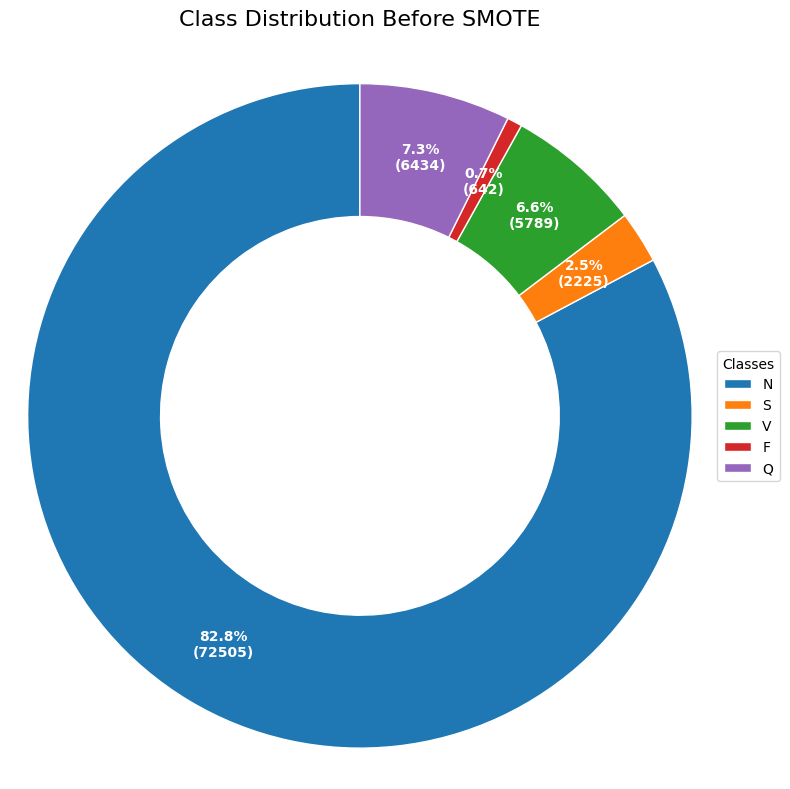

Applying SMOTE to balance and clean the training data...
SMOTE finished.


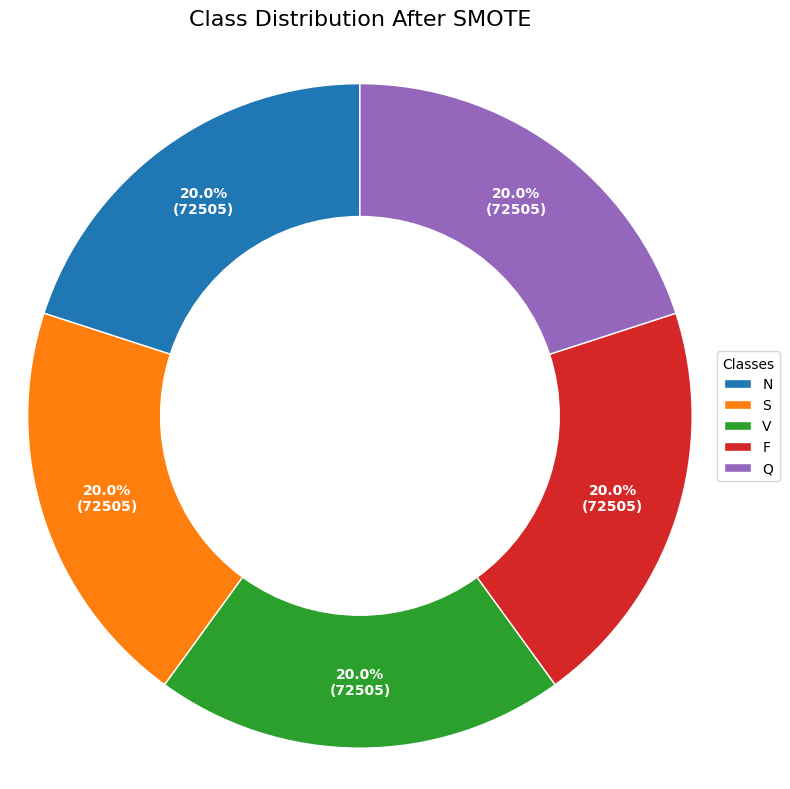

Resampling finished. New training set size: (362525, 71)

Training Simple Cascade Forest model for SSWT...
[2025-08-24 18:20:08] Fitting Layer 1/3...
[2025-08-24 18:46:54] Fitting Layer 2/3...
[2025-08-24 19:11:33] Fitting Layer 3/3...
Training finished.

----------------------------------------
RESULTS FOR: SSWT
----------------------------------------
Accuracy:  97.51%
Recall:    82.71%
Precision: 86.76%
F1 Score:  84.58%

Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.99      0.99     18126
           S       0.93      0.84      0.88       556
           V       0.90      0.88      0.89      1447
           F       0.54      0.43      0.48       161
           Q       0.99      0.99      0.99      1609

    accuracy                           0.98     21899
   macro avg       0.87      0.83      0.85     21899
weighted avg       0.97      0.98      0.97     21899

Trained model for SSWT saved to: /content/drive/MyDrive/MSc

/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=167
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=180
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=99
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=173
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=163
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=178
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWar

Dataset built with 109494 samples and 27 features.
Data split into training (87595) and testing (21899) sets.
Data split into training (87595 samples) and testing (21899 samples) sets.



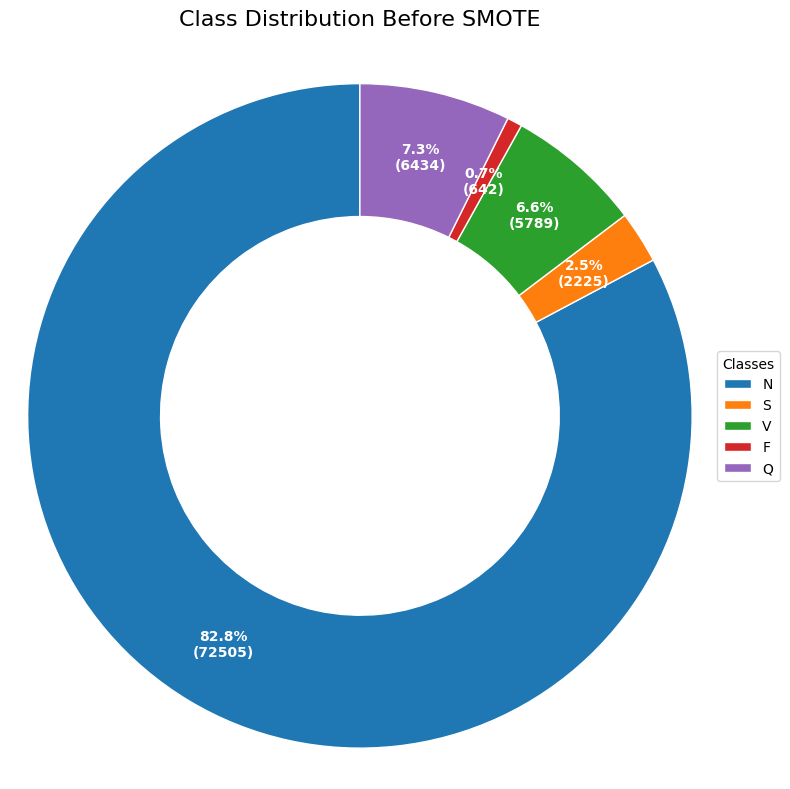

Applying SMOTE to balance and clean the training data...
SMOTE finished.


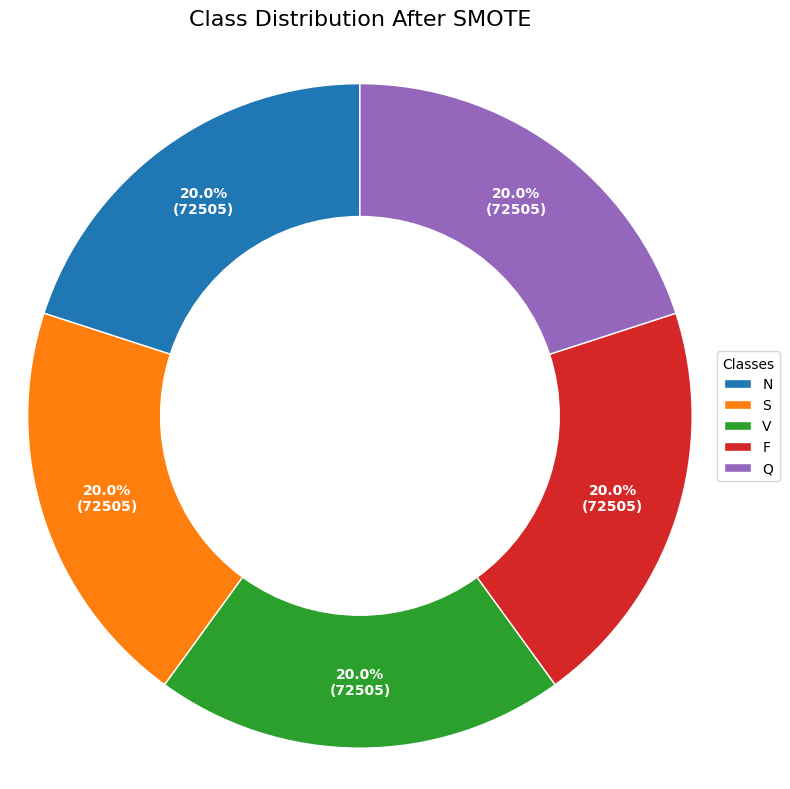

Resampling finished. New training set size: (362525, 27)

Training Simple Cascade Forest model for MFCC...
[2025-08-24 19:32:07] Fitting Layer 1/3...
[2025-08-24 19:48:18] Fitting Layer 2/3...
[2025-08-24 20:03:25] Fitting Layer 3/3...
Training finished.

----------------------------------------
RESULTS FOR: MFCC
----------------------------------------
Accuracy:  98.03%
Recall:    86.73%
Precision: 90.13%
F1 Score:  88.27%

Classification Report:
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18126
           S       0.92      0.88      0.90       556
           V       0.92      0.93      0.92      1447
           F       0.69      0.55      0.61       161
           Q       0.99      0.98      0.98      1609

    accuracy                           0.98     21899
   macro avg       0.90      0.87      0.88     21899
weighted avg       0.98      0.98      0.98     21899

Trained model for MFCC saved to: /content/drive/MyDrive/MSc

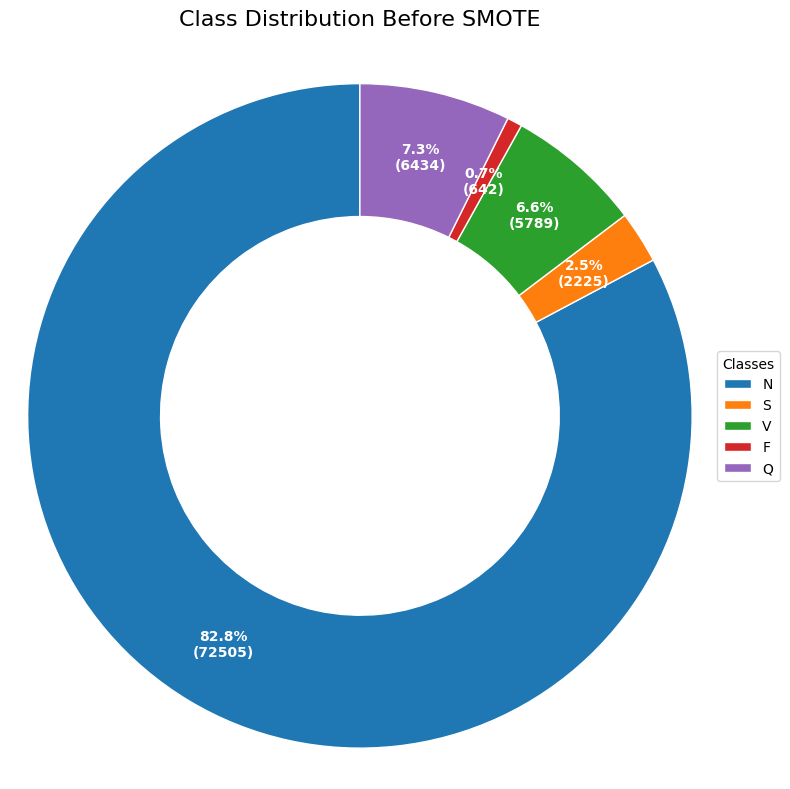

Applying SMOTE to balance and clean the training data...
SMOTE finished.


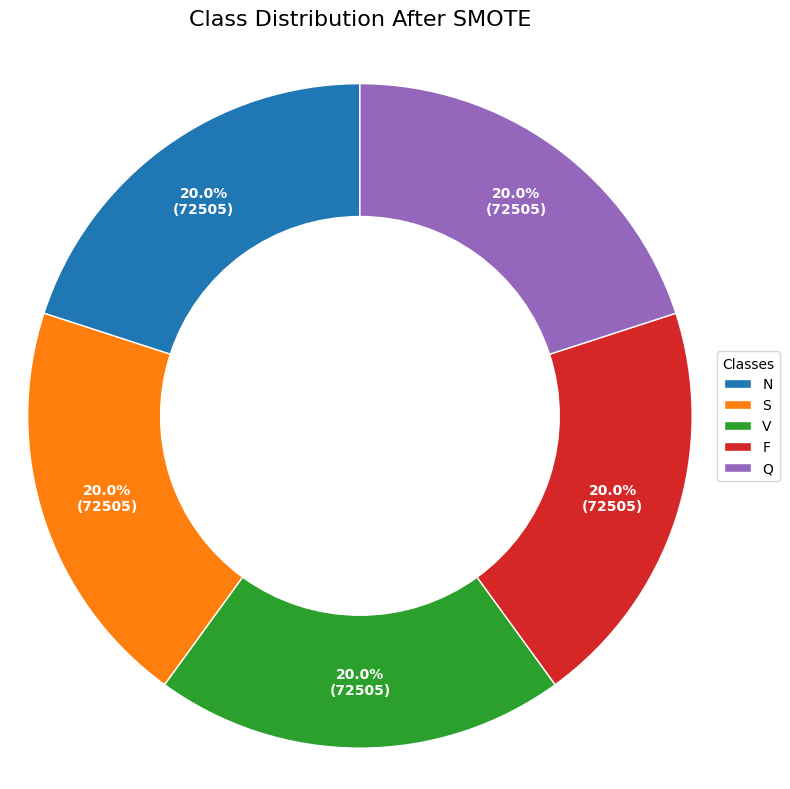

Resampling finished. New training set size: (362525, 212)

Training Simple Cascade Forest model for DWT...
[2025-08-24 20:13:04] Fitting Layer 1/3...
[2025-08-24 20:59:52] Fitting Layer 2/3...
[2025-08-24 21:40:24] Fitting Layer 3/3...
Training finished.

----------------------------------------
RESULTS FOR: DWT
----------------------------------------
Accuracy:  98.75%
Recall:    91.56%
Precision: 94.17%
F1 Score:  92.76%

Classification Report:
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18126
           S       0.91      0.90      0.90       556
           V       0.95      0.97      0.96      1447
           F       0.86      0.73      0.79       161
           Q       0.99      0.99      0.99      1609

    accuracy                           0.99     21899
   macro avg       0.94      0.92      0.93     21899
weighted avg       0.99      0.99      0.99     21899

Trained model for DWT saved to: /content/drive/MyDrive/MScUE

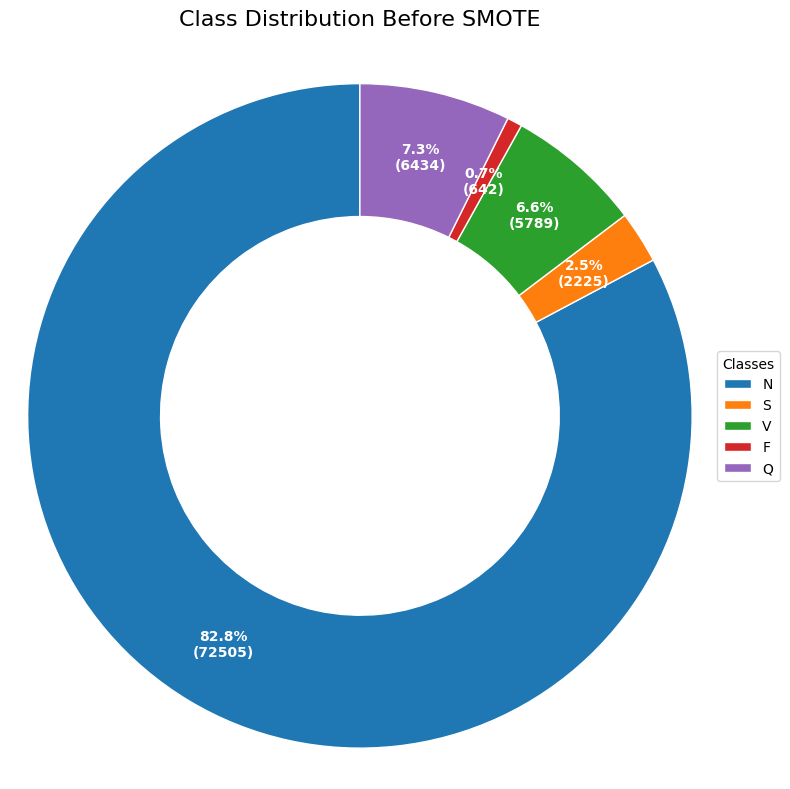

Applying SMOTE to balance and clean the training data...
SMOTE finished.


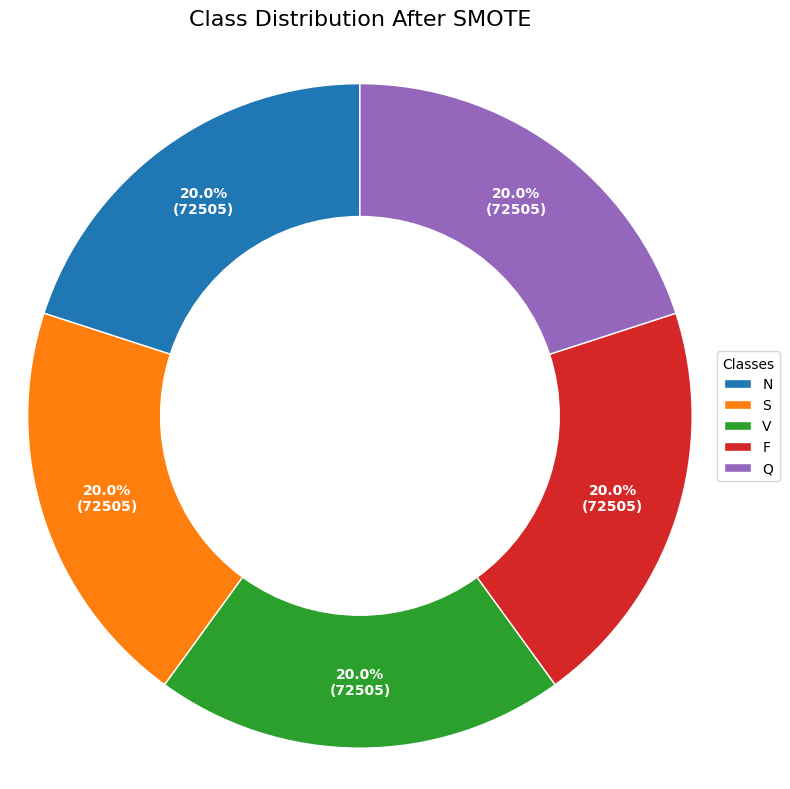

Resampling finished. New training set size: (362525, 67)

Training Simple Cascade Forest model for HHT...
[2025-08-24 22:51:19] Fitting Layer 1/3...
[2025-08-24 23:05:33] Fitting Layer 2/3...


In [ ]:
if __name__ == "__main__":
    import time

    PROJECT_PATH = '/content/drive/MyDrive/MScUEL'; DATA_PATH = os.path.join(PROJECT_PATH, 'mit-bih-arrhythmia-database-1.0.0')
    OUTPUT_PATH = os.path.join(PROJECT_PATH, 'colab_outputs_forest'); os.makedirs(OUTPUT_PATH, exist_ok=True)
    print(f"Project path set to: {PROJECT_PATH}"); print(f"Data path set to: {DATA_PATH}"); print(f"Output path set to: {OUTPUT_PATH}")


    # if not os.path.isdir(DATA_PATH):
    #     print("\nDatabase not found. Downloading...")
    #     wfdb.dl_database('mitdb', DATA_PATH)
    #     print("Download complete.")

    record_names=['100','101','102','103','104','105','106','107','108','109','111','112',
                  '113','114','115','116','117','118','119','121','122','123','124','200',
                  '201','202','203','205','207','208','209','210','212','213','214','215',
                  '217','219','220','221','222','223','228','230','231','232','233','234']

    list_of_records = []
    print("\nLoading MIT-BIH records...")
    for rec_name in record_names:

        try:
            rec_path = os.path.join(DATA_PATH, rec_name)
            rec = wfdb.rdrecord(rec_path)
            ann = wfdb.rdann(rec_path, 'atr')
            ecg_rec = ECGRecord(signal=rec.p_signal[:, 0], fs=rec.fs, ann_positions=ann.sample,
                                ann_symbols=ann.symbol, record_id=rec_name)
            list_of_records.append(ecg_rec)

        except Exception as e:
            print(f"Could not load {rec_name}. Error: {e}")
    print(f"Successfully Loaded all available records")

    if not list_of_records:
        print("\nNo records loaded. Please check the DATA_PATH.")
    else:
        start_time = time.time()
        run_comparative_experiment(list_of_records, OUTPUT_PATH)
        end_time = time.time()
        print(f"Execution time: {end_time - start_time:.4f} seconds")


## FOR BASELINE AND HHT

In [ ]:
import time
def run_comparative_experiment(records: List[ECGRecord], output_path: str, test_size: float = 0.2, random_state: int = 42):
    feature_extraction_methods = {"HHT": extract_hht_features, "Baseline": extract_no_transform_features}
    for method_name, extraction_func in feature_extraction_methods.items():
        start_time = time.time()
        print("\n" + "="*80 + f"\nRUNNING EXPERIMENT FOR: {method_name}\n" + "="*80 + "\n")
        X, y = build_dataset_from_records(records, extraction_func)
        print(f"Dataset built with {X.shape[0]} samples and {X.shape[1]} features.")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
        print(f"Data split into training ({len(X_tr)}) and testing ({len(X_te)}) sets.")
        print(f"Data split into training ({len(X_tr)} samples) and testing ({len(X_te)} samples) sets.\n")

        plot_class_distribution(y_tr, "Class Distribution Before SMOTE")

        # Apply SMOTE
        print("Applying SMOTE to balance and clean the training data...")
        smote = SMOTE(random_state=random_state)
        X_tr_resampled, y_tr_resampled = smote.fit_resample(X_tr, y_tr)
        print("SMOTE finished.")

        plot_class_distribution(y_tr_resampled, "Class Distribution After SMOTE")

        print(f"Resampling finished. New training set size: {X_tr_resampled.shape}")

        clf = CascadeForestClassifier(
            n_models_per_layer=2,
            max_layers=3,
            random_state=random_state,
            n_jobs=-1,
            verbose=1,
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2
        )
        print(f"\nTraining Simple Cascade Forest model for {method_name}...")
        clf.fit(X_tr_resampled, y_tr_resampled)
        print("Training finished.\n")

        y_pred = clf.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
        pre = precision_score(y_te, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='macro', zero_division=0)

        print("-" * 40 + f"\nRESULTS FOR: {method_name}\n" + "-" * 40)
        print(f"Accuracy:  {acc*100:.2f}%\nRecall:    {rec*100:.2f}%\nPrecision: {pre*100:.2f}%\nF1 Score:  {f1*100:.2f}%\n")
        print("Classification Report:")
        target_names = [AAMI_LABELS[i] for i in sorted(np.unique(y_te))]
        print(classification_report(y_te, y_pred, target_names=target_names, zero_division=0))

        model_path = os.path.join(output_path, f'model_forest_{method_name}.joblib')
        scaler_path = os.path.join(output_path, f'scaler_forest_{method_name}.joblib')
        joblib.dump(clf, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Trained model for {method_name} saved to: {model_path}")
        print(f"Scaler for {method_name} saved to: {scaler_path}")
        end_time = time.time()
        print(f"Execution time: {end_time - start_time:.4f} seconds")

if __name__ == "__main__":


    PROJECT_PATH = '/content/drive/MyDrive/MScUEL'; DATA_PATH = os.path.join(PROJECT_PATH, 'mit-bih-arrhythmia-database-1.0.0')
    OUTPUT_PATH = os.path.join(PROJECT_PATH, 'colab_outputs_forest'); os.makedirs(OUTPUT_PATH, exist_ok=True)
    print(f"Project path set to: {PROJECT_PATH}"); print(f"Data path set to: {DATA_PATH}"); print(f"Output path set to: {OUTPUT_PATH}")


    # if not os.path.isdir(DATA_PATH):
    #     print("\nDatabase not found. Downloading...")
    #     wfdb.dl_database('mitdb', DATA_PATH)
    #     print("Download complete.")

    record_names=['100','101','102','103','104','105','106','107','108','109','111','112',
                  '113','114','115','116','117','118','119','121','122','123','124','200',
                  '201','202','203','205','207','208','209','210','212','213','214','215',
                  '217','219','220','221','222','223','228','230','231','232','233','234']

    list_of_records = []
    print("\nLoading MIT-BIH records...")
    for rec_name in record_names:

        try:
            rec_path = os.path.join(DATA_PATH, rec_name)
            rec = wfdb.rdrecord(rec_path)
            ann = wfdb.rdann(rec_path, 'atr')
            ecg_rec = ECGRecord(signal=rec.p_signal[:, 0], fs=rec.fs, ann_positions=ann.sample,
                                ann_symbols=ann.symbol, record_id=rec_name)
            list_of_records.append(ecg_rec)

        except Exception as e:
            print(f"Could not load {rec_name}. Error: {e}")
    print(f"Successfully Loaded all available records")

    if not list_of_records:
        print("\nNo records loaded. Please check the DATA_PATH.")
    else:
        run_comparative_experiment(list_of_records, OUTPUT_PATH)



Project path set to: /content/drive/MyDrive/MScUEL
Data path set to: /content/drive/MyDrive/MScUEL/mit-bih-arrhythmia-database-1.0.0
Output path set to: /content/drive/MyDrive/MScUEL/colab_outputs_forest

Loading MIT-BIH records...
Successfully Loaded all available records

RUNNING EXPERIMENT FOR: HHT

Building dataset using 'extract_hht_features'...
